In [1]:
# Texas Real Estate Trends

In [2]:
## Importing Libraries

In [3]:
import pandas as pd

In [4]:
## Loading Data

In [5]:
df = pd.read_csv("real_estate_texas_500_2024.csv")

# will display the first few rows
df.head()

,url,status,id,listPrice,baths,baths_full,baths_full_calc,beds,sqft,stories,sub_type,text,type,year_built
0,https://www.realtor.com/realestateandhomes-det...,for_sale,9773941616,240000.0,2,2.0,2.0,3.0,1190.0,1.0,NaN,Welcome home to your peaceful retreat nestled ...,single_family,2018.0
1,https://www.realtor.com/realestateandhomes-det...,for_sale,9224923922,379900.0,4,3.0,3.0,4.0,2033.0,1.0,NaN,"Beautiful country home on 0.85 fenced acres, m...",single_family,2002.0
2,https://www.realtor.com/realestateandhomes-det...,for_sale,9840661824,370000.0,2,2.0,2.0,4.0,2062.0,1.0,NaN,PRICED TO SELL CORNER LOT HAS A STORM SHELTER ...,single_family,2012.0
3,https://www.realtor.com/realestateandhomes-det...,for_sale,7338317229,444000.0,4,3.0,3.0,5.0,3705.0,2.0,NaN,Come check out country living in the city! Are...,single_family,1985.0
4,https://www.realtor.com/realestateandhomes-det...,for_sale,7285845528,569000.0,2,2.0,2.0,3.0,3282.0,2.0,NaN,Welcome to your dream retreat! Nestled on over...,single_family,1981.0


In [6]:
# trying to figure out how many rows and columns
df.shape

(501, 14)

In [7]:
# column names, data types, missing info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   url              501 non-null    object 
 1   status           501 non-null    object 
 2   id               501 non-null    int64  
 3   listPrice        499 non-null    float64
 4   baths            501 non-null    int64  
 5   baths_full       436 non-null    float64
 6   baths_full_calc  436 non-null    float64
 7   beds             440 non-null    float64
 8   sqft             438 non-null    float64
 9   stories          391 non-null    float64
 10  sub_type         10 non-null     object 
 11  text             495 non-null    object 
 12  type             501 non-null    object 
 13  year_built       289 non-null    float64
dtypes: float64(7), int64(2), object(5)
memory usage: 54.9+ KB


In [8]:
# checking for the sum of null values in each column
df.isnull().sum()

url                  0
status               0
id                   0
listPrice            2
baths                0
baths_full          65
baths_full_calc     65
beds                61
sqft                63
stories            110
sub_type           491
text                 6
type                 0
year_built         212
dtype: int64

In [9]:
!python3 -m pip install seaborn


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [10]:
!pip show seaborn

Name: seaborn
Version: 0.13.2
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: /opt/homebrew/lib/python3.11/site-packages
Requires: matplotlib, numpy, pandas
Required-by: 


In [11]:
import sys
print(sys.executable)

/Library/Frameworks/Python.framework/Versions/3.12/bin/python3


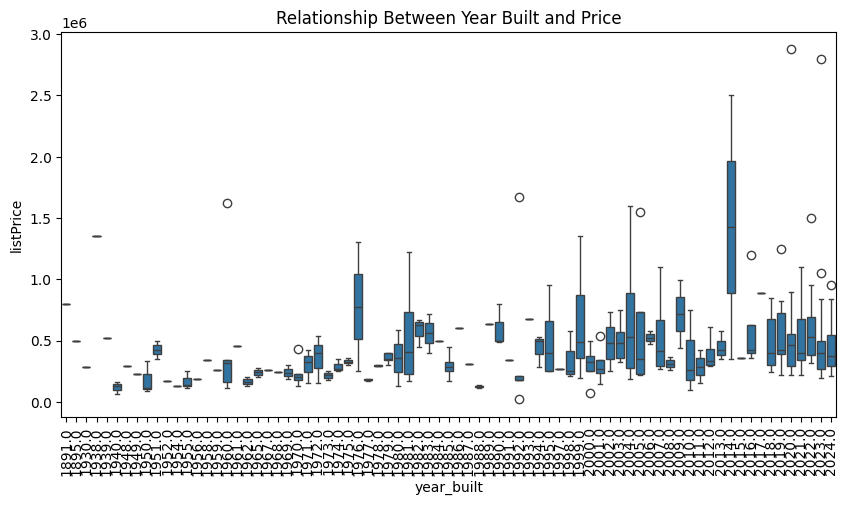

In [12]:
# realized from this that sub_type is almost entirely missing, and year_built almost. can drop sub_type, but need to check if year_built is important enough to save
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5)) # just an estimate of what will make the plot wide enough and easy to read
sns.boxplot(x=df["year_built"], y=df["listPrice"]) # good for visualizing distribution of num data across different categories (good with outliers, shows distribution, easy to compare)
plt.xticks(rotation=90) # years can be close together, can rotate to make more readable
plt.title("Relationship Between Year Built and Price")
plt.show()

In [13]:
# boxplot shows that year_built does matter in determining price, but we have 212 missing values, so what do we do?
# can use the mode of the year for the missing values

df["year_built"].mode()

0    2024.0
Name: year_built, dtype: float64

In [14]:
# comparing to see which one will work better for this situation
print("Mode:", df["year_built"].mode()[0])
print("Median:", df["year_built"].median())

Mode: 2024.0
Median: 2006.0


In [15]:
# from this we can tell hat the mode not trustworthy, its the current year, so we'll go with median
df["year_built"].isnull().sum()

212

In [16]:
# Fill missing numerical values with the median
df["beds"].fillna(df["beds"].median(), inplace=True)
df["baths_full"].fillna(df["baths_full"].median(), inplace=True)
df["sqft"].fillna(df["sqft"].median(), inplace=True)
df["stories"].fillna(df["stories"].median(), inplace=True)

In [17]:
# Check for any remaining missing values
df.isnull().sum()

url                  0
status               0
id                   0
listPrice            2
baths                0
baths_full           0
baths_full_calc     65
beds                 0
sqft                 0
stories              0
sub_type           491
text                 6
type                 0
year_built         212
dtype: int64

In [18]:
# List all column names
print(df.columns)

Index(['url', 'status', 'id', 'listPrice', 'baths', 'baths_full',
       'baths_full_calc', 'beds', 'sqft', 'stories', 'sub_type', 'text',
       'type', 'year_built'],
      dtype='object')


In [19]:
# missing too many things
# Drop column only if it exists
if "sub_type" in df.columns:
    df.drop(columns=["sub_type"], inplace=True)

# filling again
df["year_built"].fillna(df["year_built"].median(), inplace=True)
df["listPrice"].fillna(df["listPrice"].median(), inplace=True)
df["baths_full_calc"].fillna(df["baths_full"], inplace=True)

# handle text
df["text"].fillna("No description available", inplace=True)

df.isnull().sum()

url                0
status             0
id                 0
listPrice          0
baths              0
baths_full         0
baths_full_calc    0
beds               0
sqft               0
stories            0
text               0
type               0
year_built         0
dtype: int64

In [20]:
# next we need to figure out outliers
Q1 = df["listPrice"].quantile(0.25)
Q3 = df["listPrice"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier threshold
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
outliers = df[(df["listPrice"] < lower_bound) | (df["listPrice"] > upper_bound)]
print("Number of outliers detected:", outliers.shape[0])

Number of outliers detected: 30


In [21]:
# Log Transformations

# Detect outliers in listPrice
Q1 = df["listPrice"].quantile(0.25)
Q3 = df["listPrice"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier threshold
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
outliers = df[(df["listPrice"] < lower_bound) | (df["listPrice"] > upper_bound)]
print("Number of outliers detected:", outliers.shape[0])

Number of outliers detected: 30


In [22]:
print(df.columns)

Index(['url', 'status', 'id', 'listPrice', 'baths', 'baths_full',
       'baths_full_calc', 'beds', 'sqft', 'stories', 'text', 'type',
       'year_built'],
      dtype='object')


In [23]:
df.head()  # Check if 'listPrice_log' now appears in the DataFrame

,url,status,id,listPrice,baths,baths_full,baths_full_calc,beds,sqft,stories,text,type,year_built
0,https://www.realtor.com/realestateandhomes-det...,for_sale,9773941616,240000.0,2,2.0,2.0,3.0,1190.0,1.0,Welcome home to your peaceful retreat nestled ...,single_family,2018.0
1,https://www.realtor.com/realestateandhomes-det...,for_sale,9224923922,379900.0,4,3.0,3.0,4.0,2033.0,1.0,"Beautiful country home on 0.85 fenced acres, m...",single_family,2002.0
2,https://www.realtor.com/realestateandhomes-det...,for_sale,9840661824,370000.0,2,2.0,2.0,4.0,2062.0,1.0,PRICED TO SELL CORNER LOT HAS A STORM SHELTER ...,single_family,2012.0
3,https://www.realtor.com/realestateandhomes-det...,for_sale,7338317229,444000.0,4,3.0,3.0,5.0,3705.0,2.0,Come check out country living in the city! Are...,single_family,1985.0
4,https://www.realtor.com/realestateandhomes-det...,for_sale,7285845528,569000.0,2,2.0,2.0,3.0,3282.0,2.0,Welcome to your dream retreat! Nestled on over...,single_family,1981.0


In [24]:
# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=["status", "type"], drop_first=True)

In [25]:
df_encoded.head()
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   url                 501 non-null    object 
 1   id                  501 non-null    int64  
 2   listPrice           501 non-null    float64
 3   baths               501 non-null    int64  
 4   baths_full          501 non-null    float64
 5   baths_full_calc     501 non-null    float64
 6   beds                501 non-null    float64
 7   sqft                501 non-null    float64
 8   stories             501 non-null    float64
 9   text                501 non-null    object 
 10  year_built          501 non-null    float64
 11  type_farm           501 non-null    bool   
 12  type_land           501 non-null    bool   
 13  type_mobile         501 non-null    bool   
 14  type_multi_family   501 non-null    bool   
 15  type_single_family  501 non-null    bool   
 16  type_tow

In [26]:
df_encoded.drop(columns=["url", "text"], inplace=True)

In [44]:
from sklearn.preprocessing import StandardScaler

# Define the columns to scale
num_features = ["listPrice", "baths", "baths_full", "baths_full_calc", "beds", "sqft", "stories", "year_built"]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
df_encoded[num_features] = scaler.fit_transform(df_encoded[num_features])

In [45]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = df_encoded.drop(columns=["listPrice"])  # Features
y = df_encoded["listPrice"]  # Target variable (Price)

# Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the datasets
X_train.shape, X_test.shape

# Remove outliers before training the model
df = df[(df["listPrice"] >= lower_bound) & (df["listPrice"] <= upper_bound)]

In [46]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

# Train (fit) the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

print()
print(model.coef_)  # Shows how each feature affects price
print(model.intercept_)  # The base price when all features are zeroR

MAE: 0.16
RMSE: 0.24
R² Score: -0.03

[ 1.39781631e-11 -1.73037713e-01  1.00343264e-01  1.00343264e-01
  5.18655838e-02 -4.04422222e-02 -3.26926278e-03  2.32345929e-02
  7.81997488e-01 -5.84096794e-01 -4.04389847e-01 -6.61373346e-01
 -2.27298613e-01 -1.08210558e-01]
0.09426507804557321


In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Use the original dataset without scaling for Random Forest
X_rf = df_encoded.drop(columns=["listPrice"])  # Features (unscaled)
y_rf = df_encoded["listPrice"]  # Target variable (raw price)

# Train-test split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

# Train a new Random Forest model
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Make predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluate Random Forest model
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
r2_rf = r2_score(y_test_rf, y_pred_rf)

print(f"Random Forest (Unscaled) - MAE: {mae_rf:.2f}")
print(f"Random Forest (Unscaled) - RMSE: {rmse_rf:.2f}")
print(f"Random Forest (Unscaled) - R² Score: {r2_rf:.2f}")


Random Forest (Unscaled) - MAE: 0.17
Random Forest (Unscaled) - RMSE: 0.70
Random Forest (Unscaled) - R² Score: -7.81


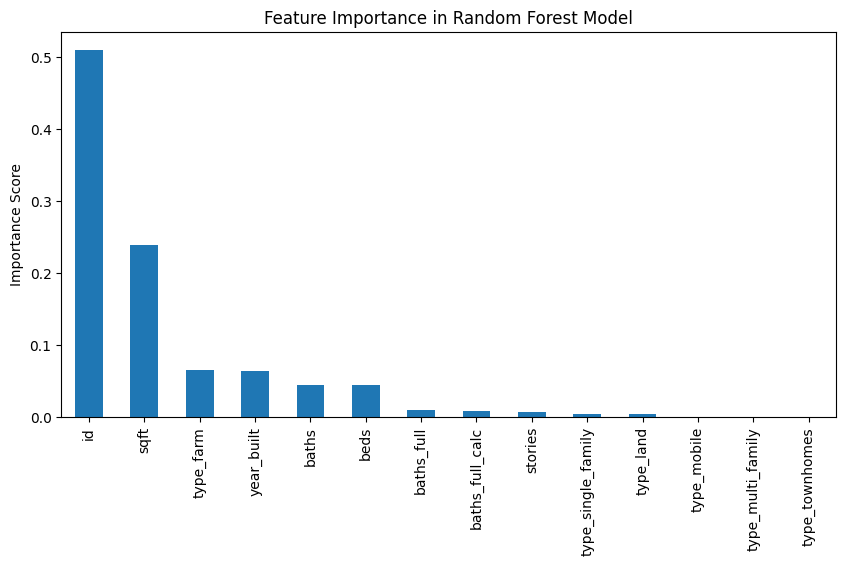

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from Random Forest
feature_importance = pd.Series(rf_model.feature_importances_, index=X_rf.columns)

# Plot feature importance
plt.figure(figsize=(10,5))
feature_importance.sort_values(ascending=False).plot(kind="bar")
plt.title("Feature Importance in Random Forest Model")
plt.ylabel("Importance Score")
plt.show()